# Read input data set.

In [1]:
import pandas as pd
df = pd.read_csv('../datasets/freesolv.csv')
df

,smiles,freesolv
0,CN(C)C(=O)c1ccc(cc1)OC,-11.01
1,CS(=O)(=O)Cl,-4.87
2,CC(C)C=C,1.83
3,CCc1cnccn1,-5.45
4,CCCCCCCO,-4.21
...,...,...
637,CCCCCCCC(=O)OC,-2.04
638,C1CCNC1,-5.48
639,c1cc(ccc1C=O)O,-8.83
640,CCCCCCCCl,0.29


In [2]:
from mgktools.data.data import Dataset
dataset = Dataset.from_df(
    df,
    pure_columns = ['smiles'],
    target_columns = ['freesolv'],
    n_jobs = 1
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 642 out of 642 | elapsed:    6.9s finished


In [3]:
# Save the dataset as dataset.pkl.
import os
if not os.path.exists('freesolv'):
    os.mkdir('freesolv')
dataset.save(path='freesolv', filename='dataset.pkl', overwrite=True)

# Set marginalized graph kernel(MGK)

In [4]:
from mgktools.kernels.utils import get_kernel_config
from mgktools.hyperparameters import product_msnorm
kernel_config = get_kernel_config(
    dataset,
    graph_kernel_type = 'graph',
    # arguments for marginalized graph kernel
    mgk_hyperparameters_files = [product_msnorm],
)
kernel = kernel_config.kernel
kernel

/home/xiangyan/apps/miniconda3/envs/mgktools/lib/python3.9/site-packages/graphdot/codegen/sympy_printer.py:4: SymPyDeprecationWarning: 

The sympy.printing.cxxcode submodule is deprecated. It has been renamed to
sympy.printing.cxx.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-printing-code-submodules
for details.

This has been deprecated since SymPy version 1.7. It
will be removed in a future version of SymPy.

  from sympy.printing.cxxcode import CXX11CodePrinter


# Compute MGK matrix

In [5]:
dataset.graph_kernel_type = 'graph'
K = kernel(dataset.X)
K

array([[1.        , 0.28764895, 0.41278771, ..., 0.83205516, 0.52607308,
        0.5176422 ],
       [0.28764895, 1.        , 0.24584692, ..., 0.23574728, 0.20222193,
        0.17237185],
       [0.41278771, 0.24584692, 1.        , ..., 0.36417745, 0.42250786,
        0.24472899],
       ...,
       [0.83205516, 0.23574728, 0.36417745, ..., 1.        , 0.45911351,
        0.53049525],
       [0.52607308, 0.20222193, 0.42250786, ..., 0.45911351, 1.        ,
        0.37867482],
       [0.5176422 , 0.17237185, 0.24472899, ..., 0.53049525, 0.37867482,
        1.        ]])

# Gaussian process regression (GPR)

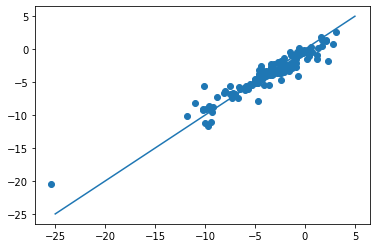

In [6]:
from mgktools.data import dataset_split
train, test = dataset_split(dataset, 
                            split_type='random',
                            sizes=[0.8, 0.2])
from mgktools.models.regression.GPRgraphdot.gpr import GPR
gpr = GPR(kernel=kernel,
          optimizer=None,
          alpha=0.01,
          normalize_y=True)
gpr.fit(train.X, train.y)
y_pred = gpr.predict(test.X)
import matplotlib.pyplot as plt
plt.scatter(test.y, y_pred)
plt.plot([-25, 5], [-25, 5])